In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install reverse_geocode -q

     |████████████████████████████████| 1.6 MB 5.3 MB/s 


In [3]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import reverse_geocode
import time
import itertools
from datetime import datetime
import pickle
from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder
from sklearn.preprocessing   import OrdinalEncoder
from sklearn.preprocessing   import MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.cluster import KMeans

from scipy.stats import mode

Create features for vendor_tag_name attribute (Food specialities available in the restaurant)

In [5]:
def add_food_cols(row,food_items):
  try:
    for item in food_items:
      row[item] = int(item in(row["vendor_tag_name"].split(',')))
  except:
    for item in food_items:
      row[item] = 0.0
  return row

**Extract working hours of the restaurant from OpeningTime attribute**

https://www.geeksforgeeks.org/python-datetime-strptime-function/

strftime() converts a time input into a string output. strptime() converts a text input into a time output.

strptime is a method available in DateTime which is used to format the time stamp which is in string format to date-time object

* hour is mostly zero padded decimal (%I)
* minute is zero padded (%M)
* AM or PM (%p)

In [6]:
def calculate_duration(timings):

  try:
    try:
      close_time = datetime.strptime(timings[1],"%I:%M%p")
    except ValueError:
      close_time = datetime.strptime(timings[1],"%I%p")
    try:
      open_time = datetime.strptime(timings[0],"%I:%M%p")
    except ValueError:
      open_time = datetime.strptime(timings[0],"%I%p")

    duration = close_time-open_time
    return round(abs(duration.total_seconds())/3600,2)

  except:
    return np.nan


In [7]:
def process_vendors(location,filename):
  vendors = pd.read_csv(location + filename)
  vendors["id"] = vendors["id"].astype('str')
  vendors.rename(columns={'id':'vendor_id'},inplace=True)

  #Create count feature for vendor_tag attribute (Number of food specialities available in the restaurant)
  vendors["tag_counts"]=vendors["vendor_tag"].str.split(',').str.len()
  vendors["tag_counts"].fillna(0,inplace=True)

  #Food specialities of the vendor
  vendor_foods = pd.unique(vendors.loc[~vendors["vendor_tag_name"].isna(),"vendor_tag_name"])
  food_list = [foods.split(',') for foods in vendor_foods] 
  food_items = list(set(itertools.chain(*food_list))) 
  vendors = vendors.apply(lambda x: add_food_cols(x,food_items=food_items),axis=1)
  
  #Extract numerical part of the primary_tags
  vendors["primary_tags"].fillna('{"primary_tags":"0"}',inplace=True) #0 is assigned for null values
  vendors["primary_tags_mod"] = vendors["primary_tags"].str.split('{"primary_tags":"').str[1].str.split('"}').str[0]  

  vendors["OpeningTime"]= vendors["OpeningTime"].str.replace(" ","").str.replace(".",":").str.replace("::",":").str.replace("111","11").str.replace('08:00AM-11:45-','08:00AM-11:45PM')
  vendors["timings"] = vendors["OpeningTime"].str.split('-')
  vendors["open_duration"] = vendors["timings"].apply(calculate_duration)
  vendors["open_duration"].fillna(round(vendors["open_duration"].mean(),2),inplace=True)

  #Time Features
  vendors["year_vendor_created"] = pd.to_datetime(vendors["created_at"]).dt.year
  vendors["month_vendor_created"] = pd.to_datetime(vendors["created_at"]).dt.month
  vendors["year_vendor_updated"] = pd.to_datetime(vendors["updated_at"]).dt.year
  vendors["month_vendor_updated"] = pd.to_datetime(vendors["updated_at"]).dt.month

  #Fix nan values for commission, language
  vendors["commission"].fillna(1.0,inplace=True)
  vendors["language"].fillna("NA",inplace=True)
  vendors["language"] = vendors["language"].map({"NA":0,"EN":1})

  #Verify vendor locations
  #All the vendor locations are in Africa except for 2 which has incorrect coordinate values
  vendors_valid = vendors[(((vendors["latitude"] >= -90.0) & (vendors["latitude"] <= 90.0)) & ((vendors["longitude"] >= -180.0) & (vendors["longitude"] <= 180.0)))]

  coordinates = list(zip(vendors_valid["latitude"],vendors_valid["longitude"]))
  vendors_valid[["country_code","vendor_city","vendor_country"]] = pd.DataFrame(reverse_geocode.search(coordinates))
  vendors_valid["vendor_city"].fillna("null",inplace=True)
  vendors_valid["vendor_country"].fillna("null",inplace=True)

  #Extract the vendor info with incorrect coordinates and set their city and country values
  vendors_invalid = vendors[~(((vendors["latitude"] >= -90.0) & (vendors["latitude"] <= 90.0)) & ((vendors["longitude"] >= -180.0) & (vendors["longitude"] <= 180.0)))]
  vendors_invalid["vendor_city"]="invalid"
  vendors_invalid["vendor_country"]="invalid"
  vendors_valid = vendors_valid.append(vendors_invalid,ignore_index=True)

  #Remove the unwanted features
  vendor_dropcols = ["vendor_tag_name","vendor_tag","vendor_category_en","authentication_id","created_at","updated_at","OpeningTime","OpeningTime2","timings","primary_tags","is_akeed_delivering","country_code","open_close_flags","one_click_vendor","country_id","city_id","display_orders",'sunday_from_time1', 'sunday_to_time1', 'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1', 'monday_to_time1', 'monday_from_time2', 'monday_to_time2', 'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2', 'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1', 'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1', 'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2', 'friday_from_time1', 'friday_to_time1', 'friday_from_time2', 'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1', 'saturday_from_time2', 'saturday_to_time2']
  vendors_valid = vendors_valid.drop(columns=vendor_dropcols)
  return vendors_valid


Generate vendor summary from orders file

In [8]:
def process_vendor_summary(location,filename):
  orders = pd.read_csv(location + filename)
  orders.drop_duplicates(subset=['akeed_order_id'],inplace=True)
  orders['created_at'] = pd.to_datetime(orders["created_at"])
  orders['delivered_time'] = pd.to_datetime(orders['delivered_time']) 
  orders[['CID','LOC_NUM','VENDOR']] = orders['CID X LOC_NUM X VENDOR'].str.split(' X ',expand=True)

  orders["preparationtime"].fillna(orders["preparationtime"].groupby(orders["VENDOR"]).transform('mean'),inplace=True)
  orders["preparationtime"].fillna(orders["preparationtime"].mean(),inplace=True)
  orders["promo_code_discount_percentage"].fillna(0,inplace=True)
  orders["is_favorite"].fillna("null",inplace=True)

  #For few records the timestamps looks to be swapped...hence absolute function
  orders["order_turnaround"] = np.abs((orders["delivered_time"] - orders["created_at"]).apply(lambda x: x.total_seconds())) #total_seconds method belongs to timedelta object

  vendor_summary = orders.groupby(orders["VENDOR"]).agg({
    'customer_id':['count','nunique'],
    'payment_mode':['nunique'],
    'promo_code':['count'],
    'vendor_discount_amount':['sum'],
    'promo_code_discount_percentage':['mean'],
    'item_count':['median'],
    'grand_total':['median'],
    'driver_rating' : ['median'],
    'deliverydistance' : ['mean'],
    'preparationtime' :['mean'],
    'order_turnaround':['min','max','mean']}).reset_index()

  vendor_summary.columns = ['_'.join(col).strip() for col in vendor_summary.columns.values]
  vendor_summary.rename(columns={'VENDOR_':'vendor_id'},inplace=True)
  
  return vendor_summary

Customer Demographics

In [9]:
def process_customer_demo(location,filename):

  customers = pd.read_csv(location + filename)
  customers["updated_at"] = pd.to_datetime(customers["updated_at"])
  customers["created_at"] = pd.to_datetime(customers["created_at"])

  #Remove duplicate records by extracting the last updated records
  customers_dedup = customers[customers["updated_at"] == customers.groupby(["akeed_customer_id"])['updated_at'].transform('max')]
  
  #remove trailing spaces in gender and convert to lower case
  customers_dedup.loc[:,"gender"] = customers_dedup["gender"].astype("str").str.rstrip().str.lower()

  #fix missing and incorrect values as 'unknown'
  customers_dedup.loc[~customers_dedup["gender"].isin(["male","female"]),"gender"] = "unknown"

  #time features
  customers_dedup['year_customer_created'] = customers_dedup['created_at'].dt.year
  customers_dedup['month_customer_created'] = customers_dedup['created_at'].dt.month
  customers_dedup['year_customer_updated'] = customers_dedup['updated_at'].dt.year
  customers_dedup['month_customer_updated'] = customers_dedup['updated_at'].dt.month
                                                    
  customers_dedup = customers_dedup[['akeed_customer_id', 'gender', 'verified', 'language', 'year_customer_created', 'month_customer_created', 'year_customer_updated', 'month_customer_updated']]

  return customers_dedup

Customer Locations

https://datascientyst.com/reverse-geocoding-latitude-longitude-city-country-python-pandas/

In [10]:
def process_customer_location(location,filename):
  
  locations = pd.read_csv(location + filename)
  locations["location_type"].fillna('Null',inplace=True)
  locations['location_type'] = locations['location_type'].map({'Null':0,'Home':1,'Work':2,'Other':3})

  locations["latitude"].fillna(locations.groupby(["customer_id"])["latitude"].transform("mean"),inplace=True)
  locations["longitude"].fillna(locations.groupby(["customer_id"])["longitude"].transform("mean"),inplace=True)
  
  locations["latitude"].fillna(locations["latitude"].mean(),inplace=True)
  locations["longitude"].fillna(locations["longitude"].mean(),inplace=True)

  locations_valid = locations[(((locations["latitude"] >= -90.0) & (locations["latitude"] <= 90.0)) & ((locations["longitude"] >= -180.0) & (locations["longitude"] <= 180.0)))]

  #Retrieve the city and country of those coordinates 
  coordinates = list(zip(locations_valid["latitude"],locations_valid["longitude"]))
  locations_valid[["country_code","customer_city","customer_country"]] = pd.DataFrame(reverse_geocode.search(coordinates))
  locations_valid.drop(columns=["country_code"],inplace=True)

  locations_valid["customer_city"].fillna("null",inplace=True)  #null for coordinates without city or country details
  locations_valid["customer_country"].fillna("null",inplace=True)
  locations_valid = locations_valid.append(locations[~(((locations["latitude"] >= -90.0) & (locations["latitude"] <= 90.0)) & ((locations["longitude"] >= -180.0) & (locations["longitude"] <= 180.0))) | locations["latitude"].isna()])
  locations_valid["customer_city"].fillna("invalid",inplace=True)
  locations_valid["customer_country"].fillna("invalid",inplace=True)

  return locations_valid

In [11]:
def haversine_np(longitude1, latitude1, longitude2, latitude2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    longitude1, latitude1, longitude2, latitude2 = map(np.radians, [longitude1, latitude1, longitude2, latitude2])

    longdiff = longitude2 - longitude1
    latdiff = latitude2 - latitude1

    a = np.sin(latdiff/2.0)**2 + np.cos(latitude1) * np.cos(latitude2) * np.sin(longdiff/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    haversine_dist = 6367 * c
    return haversine_dist

In [12]:
def merge_demo_loc_vendor(demographics_df,location_df,vendors_df):
  '''
  1. Merge demographics and location data

  2. Then merge vendors data

  3. Then merge the target
  '''
  # Merge demographics and location data
  location_demograph = location_df.merge(demographics_df,left_on="customer_id",right_on="akeed_customer_id",how="left")
  location_demograph.drop(columns=["akeed_customer_id"],inplace=True)

  # Fill for those customer-locations whose customer details are not available in customer-demographics data
  location_demograph['month_customer_updated'].fillna(99,inplace=True)
  location_demograph['month_customer_created'].fillna(99,inplace=True)
  location_demograph['year_customer_created'].fillna(9999,inplace=True)
  location_demograph['year_customer_updated'].fillna(9999,inplace=True)
  location_demograph['verified'].fillna(99,inplace=True)
  location_demograph["language"].fillna('null',inplace=True)
  location_demograph.fillna("null",inplace=True) 

  # Merge vendor data with location demograph file
  vendors_df["key"] = 1
  location_demograph["key"] = 1
  cust_vendorval = location_demograph.merge(vendors_df,on="key") #cartesian join
  cust_vendorval["CID X LOC_NUM X VENDOR"] = cust_vendorval["customer_id"] + " X " + cust_vendorval["location_number"].astype('str') + " X " + cust_vendorval["vendor_id"].astype('str')
  
  # Compute haversine distance between vendor and customer
  # Extract features comparing haversine distance and serving distance of the vendor using differences and ratios
  cust_vendorval['haversine_distance'] = haversine_np(cust_vendorval['longitude_x'],cust_vendorval['latitude_x'],cust_vendorval['longitude_y'],cust_vendorval['latitude_y'])
  cust_vendorval['distance_diff']      = cust_vendorval['haversine_distance'] - cust_vendorval['serving_distance']
  cust_vendorval['distance_ratio']     = cust_vendorval['haversine_distance'] / cust_vendorval['serving_distance']
  cust_vendorval['latitude_diff']      = cust_vendorval["latitude_x"] - cust_vendorval["latitude_y"]
  cust_vendorval['longitude_diff']     = cust_vendorval["longitude_x"] - cust_vendorval["longitude_y"]

  # Create target variable
  # Merge feature data with order data to create the target variable
  # Those with matches in the order table are considered as positive class since the customer has ordered from the vendor
  orders = pd.read_csv(input_location + orders_file)
  orders.drop_duplicates(subset=['CID X LOC_NUM X VENDOR'],inplace=True)
  orders["target"] = 1
  cust_vendorval = pd.merge(cust_vendorval,orders[['CID X LOC_NUM X VENDOR','target']],on='CID X LOC_NUM X VENDOR',how="left")
  cust_vendorval["target"].fillna(0,inplace=True)
  
  return cust_vendorval

##Separate outliers into different dataframes

1. Outlier customers are those with coordinates corresponding are outside the normal range of latitudes and longitudes.

2. Outlier vendors are those with coordinates very different from the rest.

3. Subject only valid customers buying from valid vendors (excluding outliers) to clustering

4. Separate model will be built for 
    * valid customers buying from outlier vendors
    * outlier customers buying from outlier vendors
    * outlier customers buying from valid vendors

In [13]:
def segregate_outliers(cust_vendorval):
  outlier_customer_countries = ["invalid"] #the coordinates corresponding to these countries are outside the normal range of latitudes and longitudes
  outlier_vendors = ["907","231"] #these vendor coordinates are very different from the rest
  valcust_valvendors = train_cust_vendorval.loc[((~train_cust_vendorval["customer_country"].isin(outlier_customer_countries)) & (~train_cust_vendorval["vendor_id"].isin(outlier_vendors)))].reset_index()
  valcust_outvendors = train_cust_vendorval.loc[((~train_cust_vendorval["customer_country"].isin(outlier_customer_countries)) & (train_cust_vendorval["vendor_id"].isin(outlier_vendors)))].reset_index()
  outcust_outvendors = train_cust_vendorval.loc[((train_cust_vendorval["customer_country"].isin(outlier_customer_countries)) & (train_cust_vendorval["vendor_id"].isin(outlier_vendors)))].reset_index()
  outcust_valvendors = train_cust_vendorval.loc[((train_cust_vendorval["customer_country"].isin(outlier_customer_countries)) & (~train_cust_vendorval["vendor_id"].isin(outlier_vendors)))].reset_index()

  return valcust_valvendors, valcust_outvendors, outcust_outvendors, outcust_valvendors

In [14]:
def prep_clustering_input(valcust_valvendors,is_train="Y"):
  clustering_input_cols = ['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y', 'haversine_distance', 'distance_diff','distance_ratio','latitude_diff','longitude_diff',
                              'is_open','Arabic', 'Crepes', 'Kushari', 'Shawarma', 'Fries', 'Manakeesh', 'Mojitos', 
                              'Organic', 'Frozen yoghurt', 'Sweets', 'Coffee', 'Donuts', 'Hot Chocolate', 'American', 'Rice', 'Thali', 'Healthy Food',
                              'Bagels', 'Combos', 'Chinese', 'Free Delivery', 'Kebabs', 'Desserts', 'Waffles', 'Churros', 'Salads', 'Pastas', 
                              'Fresh Juices', 'Seafood', 'Milkshakes', 'Karak', 'Cafe', 'Biryani', 'Ice creams', 'Pizzas', 'Kids meal', 'Japanese', 
                              'Cakes', 'Pasta', 'Steaks', 'Indian', 'Sandwiches', 'Vegetarian', 'Thai', 'Spanish Latte', 'Italian', 'Fatayers', 
                              'Pancakes', 'Smoothies', 'Hot Dogs', 'Mandazi', 'Dimsum', 'Pizza', 'Burgers', 'Rolls', 'Grills', 'Pastry', 'Sushi', 
                              'Family Meal', 'Breakfast', 'Lebanese', 'Omani', 'Asian', 'Mojitos ', 'Shuwa',
                              'Mexican', 'Soups', 'Mishkak', 'open_duration']

  to_normalize_cols = ['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y', 'haversine_distance', 'distance_diff','distance_ratio',
                     'latitude_diff','longitude_diff','open_duration']

  clustering_input = valcust_valvendors[clustering_input_cols]
  
  if is_train == "Y":
    mmscaler = MinMaxScaler()
    mmscaler.fit(clustering_input[to_normalize_cols])
    pickle.dump(mmscaler, open(output_location1 + 'vendcust_cluster_scaler.pkl', 'wb'))

  else:
    mmscaler = pickle.load(open(output_location1 + "vendcust_cluster_scaler.pkl","rb"))

  clustering_input[to_normalize_cols] = pd.DataFrame(mmscaler.transform(clustering_input[to_normalize_cols].to_numpy()),columns = to_normalize_cols)

  return clustering_input
    

In [15]:
input_location = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/kaggle_data/"
output_location1 = "/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendor_customer/"
train_customer_demographics = "train_customers.csv"
test_customer_demographics = "test_customers.csv"
train_customer_locations = "train_locations.csv"
test_customer_locations  = "test_locations.csv"
vendor_file = "vendors.csv"
orders_file = "orders.csv"

customer_similarity_features = ["customer_id","location_number","location_type",'latitude', 'longitude','gender', 'verified', 'language','year_customer_created', 'month_customer_created']
categ_to_num = ["gender","verified","language","year_customer_created","month_customer_created"]
categ_to_ohe = ["location_type",'gender', 'verified', 'language','year_customer_created', 'month_customer_created']
num_cols = ['customer_id','location_number','latitude','longitude']  #'customer_id','location' added as key

Process and Extract Vendor features

In [16]:
vendors = process_vendors(input_location,vendor_file)
vendor_summary = process_vendor_summary(input_location,orders_file)
vendors = pd.merge(vendors,vendor_summary,on=["vendor_id"],how="inner")
vendor_locations = vendors[['vendor_id','latitude', 'longitude']]
vendors.shape

(100, 107)

Process and Merge customer demographics and customer location data

In [17]:
train_customers = process_customer_demo(input_location,train_customer_demographics)
train_locations = process_customer_location(input_location,train_customer_locations)
train_cust_vendorval  = merge_demo_loc_vendor(train_customers,train_locations,vendors)    
train_valcust_valvendors, train_valcust_outvendors, train_outcust_outvendors, train_outcust_valvendors = segregate_outliers(train_cust_vendorval)   

print(train_customers.shape)
print(train_locations.shape)
print(train_cust_vendorval.shape)
print("train_cust_vendorval - positive{} - negative{}".format(train_cust_vendorval[train_cust_vendorval["target"] == 1].shape,train_cust_vendorval[train_cust_vendorval["target"] == 0].shape))

print("Valid customers buying from valid vendors: ",train_valcust_valvendors.shape)
print("Valid customers buying from outlier vendors: ",train_valcust_outvendors.shape)
print("Outlier customers buying from outlier vendors: ",train_outcust_outvendors.shape)
print("Outlier customers buying from valid vendors: ",train_outcust_valvendors.shape)

(34523, 8)
(59503, 7)
(5950300, 129)
train_cust_vendorval - positive(80142, 129) - negative(5870158, 129)
Valid customers buying from valid vendors:  (5701150, 130)
Valid customers buying from outlier vendors:  (116350, 130)
Outlier customers buying from outlier vendors:  (2656, 130)
Outlier customers buying from valid vendors:  (130144, 130)


##Perform Clustering on Valid Customers buying from Valid Vendors

In [18]:
import gc
del train_cust_vendorval, train_locations, train_customers
gc.collect()

72

In [19]:
train_clustering_input = prep_clustering_input(train_valcust_valvendors,is_train="Y")
print(train_clustering_input.shape)

(5701150, 79)


####Identify optimal number of clusters for the data
https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

In [ ]:
def determine_number_clusters(clustering_input):

  metric_cost_dict = dict()

  for k in tqdm([2, 3, 5, 10, 15,20,25,30,35,40]):
    kmeans = KMeans(n_clusters=k, n_init=10,random_state=7)
    kmeans.fit(clustering_input)
    y_cluster = kmeans.labels_
  
    metric_cost_dict[k] = kmeans.inertia_  

  plt.plot(list(metric_cost_dict.keys()),list(metric_cost_dict.values()),'bx-')
  plt.xlabel('k values') 
  plt.ylabel('Sum of squared distances') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

  metric_key = list(metric_cost_dict.keys())
  metric_values = list(metric_cost_dict.values())
  diff_dict = dict()
  for ind in range(1,len(metric_cost_dict)):
    diff_dict[metric_key[ind]] = (metric_values[ind-1] - metric_values[ind]) / metric_values[ind-1]

  print(" ")
  plt.plot(list(diff_dict.keys()),list(diff_dict.values()),'bx-')
  plt.xlabel('k values') 
  plt.ylabel('Inertia Differences') 
  plt.title('Elbow Method For Optimal k')
  plt.show()

  chosen_clusters = sorted(diff_dict.items(),key=lambda x: x[1])[0][0]

  return metric_cost_dict, diff_dict, chosen_clusters

100%|██████████| 10/10 [33:28<00:00, 200.88s/it]


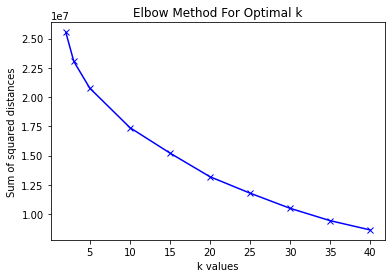

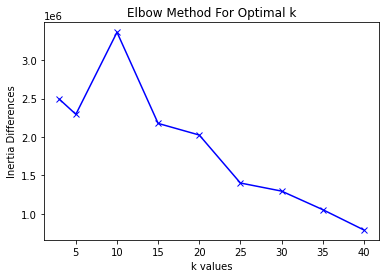

In [ ]:
metric_cost_dict, diff_dict, n_clusters = determine_number_clusters(train_clustering_input)

40 is the chosen number of clusters

####Cluster data using the optimal number of clusters chosen

In [20]:
#Clustering using the selected k hyperparameter
def cluster_data(clustering_input, chosen_clusters,is_train="Y"):

  if is_train == "Y":
    kmeans = KMeans(n_clusters = chosen_clusters, n_init=10, random_state=7)
    kmeans.fit(clustering_input)
    pred_cluster = kmeans.labels_
    
    pickle.dump(kmeans, open(output_location1 + "vendcust_cluster.pkl", "wb"))
  else:
    cluster_model = pickle.load(open(output_location1 + "vendcust_cluster.pkl", "rb"))
    pred_cluster   = cluster_model.predict(clustering_input)
    
  clustering_input["cluster"]  = pred_cluster

  return clustering_input

In [ ]:
train_clustering_input = cluster_data(train_clustering_input,n_clusters,is_train="Y")
train_valcust_valvendors["cluster"] = train_clustering_input["cluster"]
#Assign cluster number to the remaining files
train_valcust_outvendors["cluster"] = 40
train_outcust_outvendors["cluster"] = 41
train_outcust_valvendors["cluster"] = 42
train_valcust_valvendors.groupby(["cluster"])["CID X LOC_NUM X VENDOR"].count() #check how many records have gone to each cluster

cluster
0     274175
1      58179
2      58175
3     418147
4     470010
5     116350
6     391676
7     116350
8     195840
9     152059
10    156671
11     97840
12    190069
13    117503
14     78338
15     58175
16    117507
17     58175
18    116350
19    152057
20    272522
21    313343
22     58175
23    174525
24    195841
25     95035
26     97344
27     97344
28     97344
29     58175
30     77183
31    116350
32    209082
33     57022
34     58175
35     58175
36     58175
37     97344
38     58175
39     58175
Name: CID X LOC_NUM X VENDOR, dtype: int64

In [ ]:
del train_clustering_input
gc.collect()

Customer Vendor Clustering Ends Here

##Convert categorical features to numerical features for LGBM model

In [21]:
def prep_categ_features_lgbm(valcust_valvendors,valcust_outvendors, outcust_outvendors, outcust_valvendors, is_train="Y"):

  convert_cols = ["customer_city","customer_country","vendor_city","vendor_country","gender","verified_x","language_x","year_customer_created","month_customer_created","year_customer_updated","month_customer_updated",
                "vendor_category_id","delivery_charge","serving_distance","prepration_time","discount_percentage","rank","vendor_rating",
                "device_type","tag_counts","primary_tags_mod","primary_tags_mod","year_vendor_created","month_vendor_created", 
                "year_vendor_updated", "month_vendor_updated"]

  dropcols = ['customer_id', 'location_number','key', 'vendor_id']
  valcust_valvendors.drop(columns=dropcols,inplace=True)
  valcust_outvendors.drop(columns=dropcols,inplace=True)
  outcust_outvendors.drop(columns=dropcols,inplace=True)
  outcust_valvendors.drop(columns=dropcols,inplace=True)

  if is_train == "Y":
    valcust_valvendors_enc = OrdinalEncoder()
    valcust_valvendors_enc.fit(valcust_valvendors[convert_cols])
    valcust_valvendors[convert_cols] = valcust_valvendors_enc.transform(valcust_valvendors[convert_cols])
    pickle.dump(valcust_valvendors_enc, open(output_location1 + "valcust_valvendors_encoder.pkl","wb"))

    valcust_outvendors_enc = OrdinalEncoder()
    valcust_outvendors_enc.fit(valcust_outvendors[convert_cols])
    valcust_outvendors[convert_cols] = valcust_outvendors_enc.transform(valcust_outvendors[convert_cols])
    pickle.dump(valcust_outvendors_enc, open(output_location1 + "valcust_outvendors_encoder.pkl","wb"))

    outcust_outvendors_enc = OrdinalEncoder()
    outcust_outvendors_enc.fit(outcust_outvendors[convert_cols])
    outcust_outvendors[convert_cols] = outcust_outvendors_enc.transform(outcust_outvendors[convert_cols])
    pickle.dump(outcust_outvendors_enc, open(output_location1 + "outcust_outvendors_encoder.pkl","wb"))

    outcust_valvendors_enc = OrdinalEncoder()
    outcust_valvendors_enc.fit(outcust_valvendors[convert_cols])
    outcust_valvendors[convert_cols] = outcust_valvendors_enc.transform(outcust_valvendors[convert_cols])
    pickle.dump(outcust_valvendors_enc, open(output_location1 + "outcust_valvendors_encoder.pkl","wb"))

  else:

    valcust_valvendors_enc = pickle.load(open(output_location1 + "valcust_valvendors_encoder.pkl","rb"))
    valcust_valvendors[convert_cols] = valcust_valvendors_enc.transform(valcust_valvendors[convert_cols])
    
    valcust_outvendors_enc = pickle.load(open(output_location1 + "valcust_outvendors_encoder.pkl","rb"))
    valcust_outvendors[convert_cols] = valcust_outvendors_enc.transform(valcust_outvendors[convert_cols])
    
    outcust_outvendors_enc = pickle.load(open(output_location1 + "outcust_outvendors_encoder.pkl","rb"))
    outcust_outvendors[convert_cols] = outcust_outvendors_enc.transform(outcust_outvendors[convert_cols])
    
    outcust_valvendors_enc = pickle.load(open(output_location1 + "outcust_valvendors_encoder.pkl","rb"))
    outcust_valvendors[convert_cols] = outcust_valvendors_enc.transform(outcust_valvendors[convert_cols])
    
  return valcust_valvendors, valcust_outvendors, outcust_outvendors, outcust_valvendors
  

In [ ]:
train_valcust_valvendors, train_valcust_outvendors, train_outcust_outvendors, train_outcust_valvendors = prep_categ_features_lgbm(train_valcust_valvendors,train_valcust_outvendors, train_outcust_outvendors, train_outcust_valvendors, is_train="Y")

##Save feature data cluster-wise
This was done to circumvent the memory problem

In [ ]:
cluster_df = valcust_valvendors.groupby(["cluster"])["CID X LOC_NUM X VENDOR"].count().reset_index()
cluster_df.sort_values(by="CID X LOC_NUM X VENDOR",ascending=False,inplace=True)
cluster_ids = cluster_df["cluster"]

In [ ]:
cluster_df.to_csv(("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/"+"cluster_vendcust.csv"))

In [ ]:
#cluster_ids
for c_id in cluster_ids:
  globals()["train_valcust_valvendors_clus"+str(int(c_id))] = valcust_valvendors[valcust_valvendors["cluster"] == c_id]
  globals()["train_valcust_valvendors_clus"+str(int(c_id))].to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv")
  globals()["train_valcust_valvendors_clus"+str(int(c_id))].shape

In [ ]:
c_id=40
valcust_outvendors.to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv")
c_id=41
outcust_outvendors.to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv")
c_id=42
outcust_valvendors.to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv")

##Cluster-wise modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [23]:
from sklearn import metrics
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
import ast
import lightgbm as lgb
import sklearn.externals
import joblib

In [24]:
cat_features = ['location_type','customer_city', 'customer_country', 'gender', 'verified_x','language_x', 'year_customer_created', 
                'month_customer_created', 'year_customer_updated', 'month_customer_updated','vendor_category_id', 'delivery_charge', 
                'serving_distance', 'is_open', 'prepration_time', 'commission', 'discount_percentage', 'status', 'verified_y', 'rank', 
                'language_y', 'vendor_rating', 'device_type', 'tag_counts','Pasta', 'Shawarma', 'Frozen yoghurt', 'Waffles', 'Mojitos ', 
                'Kushari', 'Indian', 'Free Delivery', 'Soups', 'Mojitos', 'Vegetarian', 'Mexican', 'Dimsum', 'Smoothies', 'Grills', 'Desserts', 
                'Fresh Juices', 'Rice','Pastas', 'Pancakes', 'Omani', 'Combos', 'Bagels', 'Kids meal', 'Breakfast', 'Lebanese', 'Spanish Latte', 
                'Steaks', 'Organic', 'Sushi', 'Milkshakes', 'Pizza', 'American', 'Churros', 'Biryani', 'Family Meal', 'Chinese', 'Seafood', 'Pastry', 
                'Healthy Food', 'Donuts', 'Mishkak', 'Hot Dogs', 'Cakes', 'Coffee', 'Manakeesh', 'Shuwa', 'Burgers', 'Sandwiches', 'Thai', 'Japanese', 'Karak', 
                'Kebabs', 'Arabic', 'Cafe', 'Mandazi', 'Salads', 'Hot Chocolate', 'Thali', 'Fatayers', 'Sweets', 'Asian', 'Ice creams', 'Italian', 'Pizzas', 
                'Rolls', 'Crepes', 'Fries','primary_tags_mod', 'year_vendor_created', 'month_vendor_created', 'year_vendor_updated', 'month_vendor_updated', 
                'vendor_city', 'vendor_country']

In [25]:
num_features = ['latitude_x', 'longitude_x','latitude_y', 'longitude_y','open_duration','customer_id_count', 'customer_id_nunique', 
                'payment_mode_nunique', 'promo_code_count', 'vendor_discount_amount_sum', 'promo_code_discount_percentage_mean', 
                'item_count_median', 'grand_total_median', 'driver_rating_median', 'deliverydistance_mean', 'preparationtime_mean', 
                'order_turnaround_min', 'order_turnaround_max', 'order_turnaround_mean','haversine_distance', 
                'distance_diff', 'distance_ratio', 'latitude_diff','longitude_diff']

Read the cluster data - file where the cluster ids are ordered by size

In [26]:
cluster_df = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/"+"cluster_vendcust.csv",index_col=False)
cluster_df.drop(columns = ["Unnamed: 0"],inplace=True)
clusters = cluster_df["cluster"].tolist()
cluster_df.head()

,cluster,CID X LOC_NUM X VENDOR
0,4,470010
1,3,418147
2,6,391676
3,21,313343
4,0,274175


This method builds the lgbm classifier model along with its hyperparameter space

In [27]:
def preprocess_lgbmodel(pos,neg):
  if pos != 0:
    class_weight = round(np.sqrt(neg/pos))
  else:
    class_weight = 1

  #model and its parameters
  param ={'n_estimators':[20,50,75,100,150],
        'learning_rate':[0.005,0.01,0.05,0.1],
        'num_leaves': sp_randint(20,100) 
        }


  clf_dt = lgb.LGBMClassifier(categorical_features=cat_features,
      boosting_type='gbdt', objective='binary', scale_pos_weight= class_weight, #is_unbalance=True,
      subsample=0.8,feature_fraction=0.9,max_depth=-1,
      random_state=7)
  
  return clf_dt, param

This method builds the lgbm classifier model for the best hyperparameters

In [28]:
def define_best_lgbmodel(chosen_params,pos,neg):

  #https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
  if pos != 0:
    class_weight = round(np.sqrt(neg/pos))
  else:
    class_weight = 1


  best_clf = lgb.LGBMClassifier(learning_rate=chosen_params["learning_rate"],
                                n_estimators=chosen_params["n_estimators"],
                                num_leaves=chosen_params["num_leaves"],
                                boosting_type='gbdt', objective='binary', 
                                scale_pos_weight= class_weight,
                                subsample=0.8,feature_fraction=0.9,max_depth=-1,random_state=7)
  
  return best_clf

This method 
* reads cluster-wise feature data
* does hyperparameter tuning for lgbm models
* trains the best model 
* predicts using the best model
* saves the best model for later usage

In [29]:
def search_hyper_lgbmodel(c_id):
  
  train_cust_vendorval_clus = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv")
  train_cust_vendorval_clus.drop(columns = ["Unnamed: 0"],inplace=True)
  #form X_train and y_train using the cluster data
  y_train = train_cust_vendorval_clus["target"].values
  X_train = train_cust_vendorval_clus.drop(columns=["target","CID X LOC_NUM X VENDOR","cluster"])

  pos = np.count_nonzero(y_train == 1)
  neg = np.count_nonzero(y_train == 0)
  print("cluster:{} ; total_samples:{} ; positives:{} ; negatives:{}".format(c_id,X_train.shape[0],pos,neg))

  #define the model, its hyperparameter space and do required data preprocessing if any
  model,param = preprocess_lgbmodel(pos,neg)
  
  #using RandomizedSearchCV to search for hyperparameters with k-fold cross validation
  cv_fold = 7
  score = 'f1'
  nbr_combos = 8
  srch_model = RandomizedSearchCV(model, param ,cv=cv_fold,scoring=score,return_train_score=True,n_iter=nbr_combos,random_state=7,verbose=100)  
  clf_model = srch_model.fit(X_train,y_train)  

  #retrieve the best hyperparameters
  best_params = clf_model.best_params_  #retrieve the best hyperparameters after training
  print("Best_Hyperparameters: \n",best_params)
  
  return best_params
  

In [ ]:
best_params_dict = dict()

for c_id in clusters:
  model_params = search_hyper_lgbmodel(c_id)
  best_params_dict[c_id] = model_params

best_params_df = pd.DataFrame(list(best_params_dict.items()),columns=["cluster","best_hypers"])
#best_params_df.to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"lgb_params.csv")

cluster:4 ; total_samples:470010 ; positives:5178 ; negatives:464832
Fitting 7 folds for each of 8 candidates, totalling 56 fits
[CV 1/7; 1/8] START learning_rate=0.1, n_estimators=150, num_leaves=45..........
[CV 1/7; 1/8] END learning_rate=0.1, n_estimators=150, num_leaves=45;, score=(train=0.255, test=0.000) total time=   6.3s
[CV 2/7; 1/8] START learning_rate=0.1, n_estimators=150, num_leaves=45..........
[CV 2/7; 1/8] END learning_rate=0.1, n_estimators=150, num_leaves=45;, score=(train=0.267, test=0.109) total time=   5.8s
[CV 3/7; 1/8] START learning_rate=0.1, n_estimators=150, num_leaves=45..........
[CV 3/7; 1/8] END learning_rate=0.1, n_estimators=150, num_leaves=45;, score=(train=0.249, test=0.112) total time=   5.8s
[CV 4/7; 1/8] START learning_rate=0.1, n_estimators=150, num_leaves=45..........
[CV 4/7; 1/8] END learning_rate=0.1, n_estimators=150, num_leaves=45;, score=(train=0.258, test=0.111) total time=   5.8s
[CV 5/7; 1/8] START learning_rate=0.1, n_estimators=150, nu

In [ ]:
best_params_df.to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"lgb_params_new.csv")

This method uses the hyperparameters identified for every cluster and trains the model using it

Here train data is split into train and CV

In [30]:
def train_predict_lgbmodel(c_id,best_params):

  train_cust_vendorval_clus = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv",index_col=None)
  train_cust_vendorval_clus.drop(columns = ["Unnamed: 0","index"],inplace=True)
  #form X_train and y_train using the cluster data
  y_train = train_cust_vendorval_clus["target"].values
  X_train = train_cust_vendorval_clus.drop(columns=["target","CID X LOC_NUM X VENDOR","cluster"])

  X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)
  
  pos = np.count_nonzero(y_train == 1)
  neg = np.count_nonzero(y_train == 0)
  print("Train for cluster:{} ; total_samples:{} ; positives:{} ; negatives:{}".format(c_id,X_train.shape[0],pos,neg))
  print("CV for cluster:{} ; total_samples:{} ; positives:{} ; negatives:{}".format(c_id,X_cv.shape[0],np.count_nonzero(y_cv == 1),np.count_nonzero(y_cv == 0)))
  
  #fit the model with the chosen hyperparameters
  best_model = define_best_lgbmodel(best_params,pos,neg)
  best_model.fit(X_train,y_train) 
  ypred_cv = best_model.predict(X_cv) 
  ypred_train = best_model.predict(X_train) 
  
  #saves the best model for later usage
  joblib.dump(best_model,'/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust_models/'+'clus'+str(int(c_id))+'_lgb.pkl')

  return y_cv, ypred_cv, ypred_train, y_train

In [31]:
import ast
best_params_df = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"lgb_params_new.csv")

X_cv_all = pd.DataFrame()
y_true_cv_all = np.empty((0,1), float)
y_pred_cv_all = np.empty((0,1), float)

y_true_train_all = np.empty((0,1), float)
y_pred_train_all = np.empty((0,1), float)

for c_id in clusters:
  #get the hyperparameters for the cluster
  best_params = ast.literal_eval(best_params_df.loc[best_params_df["cluster"] == c_id,"best_hypers"].reset_index(drop=True)[0])

  y_cv, ypred_cv, ypred_train, y_train = train_predict_lgbmodel(c_id, best_params)

  y_true_cv_all = np.append(y_true_cv_all,y_cv)
  y_pred_cv_all = np.append(y_pred_cv_all,ypred_cv)
  
  y_true_train_all = np.append(y_true_train_all,y_train)
  y_pred_train_all = np.append(y_pred_train_all,ypred_train)

Train for cluster:4 ; total_samples:376008 ; positives:4142 ; negatives:371866
CV for cluster:4 ; total_samples:94002 ; positives:1036 ; negatives:92966
Train for cluster:3 ; total_samples:334517 ; positives:6914 ; negatives:327603
CV for cluster:3 ; total_samples:83630 ; positives:1728 ; negatives:81902
Train for cluster:6 ; total_samples:313340 ; positives:3891 ; negatives:309449
CV for cluster:6 ; total_samples:78336 ; positives:973 ; negatives:77363
Train for cluster:21 ; total_samples:250674 ; positives:4284 ; negatives:246390
CV for cluster:21 ; total_samples:62669 ; positives:1071 ; negatives:61598
Train for cluster:0 ; total_samples:219340 ; positives:3814 ; negatives:215526
CV for cluster:0 ; total_samples:54835 ; positives:954 ; negatives:53881
Train for cluster:20 ; total_samples:218017 ; positives:5446 ; negatives:212571
CV for cluster:20 ; total_samples:54505 ; positives:1362 ; negatives:53143
Train for cluster:32 ; total_samples:167265 ; positives:2009 ; negatives:165256


In [32]:
def plot_confusion_matrix(conf_matrix):
  ax= plt.subplot()
  sns.heatmap(conf_matrix, annot=True,cmap='Blues',ax=ax,fmt='d')
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_ylim(2.0, 0)
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(['Negative','Positive']) 
  ax.yaxis.set_ticklabels(['Negative','Positive'])
  plt.show()
  return None

CV data - F1 score 0.6
Train data - F1 score 0.66

CV Classification Report and Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   1124390
         1.0       0.18      0.27      0.21     15849

    accuracy                           0.97   1140239
   macro avg       0.58      0.63      0.60   1140239
weighted avg       0.98      0.97      0.98   1140239



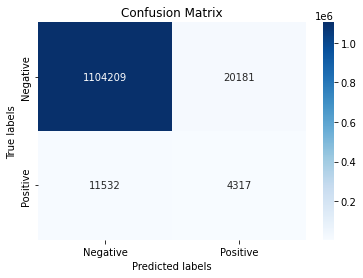



Train Classification Report and Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99   4497509
         1.0       0.27      0.42      0.33     63402

    accuracy                           0.98   4560911
   macro avg       0.63      0.70      0.66   4560911
weighted avg       0.98      0.98      0.98   4560911



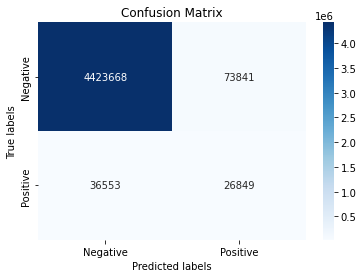

In [37]:
#Consolidated result from all cluster models
print("CV data - F1 score", round(f1_score(y_true_cv_all, y_pred_cv_all,average='macro'),2))
print("Train data - F1 score", round(f1_score(y_true_train_all, y_pred_train_all,average='macro'),2))

print("")
print("CV Classification Report and Confusion Matrix")
print(metrics.classification_report(y_true_cv_all, y_pred_cv_all))
plot_confusion_matrix(metrics.confusion_matrix(y_true_cv_all, y_pred_cv_all))

print("")
print("\nTrain Classification Report and Confusion Matrix")
print(metrics.classification_report(y_true_train_all, y_pred_train_all))
plot_confusion_matrix(metrics.confusion_matrix(y_true_train_all, y_pred_train_all))

In [ ]:
test_customers = process_customer_demo(input_location,test_customer_demographics)
test_locations = process_customer_location(input_location,test_customer_locations)
test_cust_vendorval  = merge_demo_loc_vendor(test_customers,test_locations,vendors) 
test_valcust_valvendors, test_valcust_outvendors, test_outcust_outvendors, test_outcust_valvendors = segregate_outliers(test_cust_vendorval)   


print(test_customers.shape)
print(test_locations.shape)
print(test_cust_vendorval.shape)
print("test_cust_vendorval - positive{} - negative{}".format(test_cust_vendorval[test_cust_vendorval["target"] == 1].shape,test_cust_vendorval[test_cust_vendorval["target"] == 0].shape))

print("Valid customers buying from valid vendors: ",test_valcust_valvendors.shape)
print("Valid customers buying from outlier vendors: ",test_valcust_outvendors.shape)
print("Outlier customers buying from outlier vendors: ",test_outcust_outvendors.shape)
print("Outlier customers buying from valid vendors: ",test_outcust_valvendors.shape)

##Train using Random Forest Classifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [39]:
from sklearn import metrics
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score
import sklearn.externals
import joblib
import pickle

In [40]:
cat_features = ['location_type','customer_city', 'customer_country', 'gender', 'verified_x','language_x', 'year_customer_created', 
                'month_customer_created', 'year_customer_updated', 'month_customer_updated','vendor_category_id', 'delivery_charge', 
                'serving_distance', 'is_open', 'prepration_time', 'commission', 'discount_percentage', 'status', 'verified_y', 'rank', 
                'language_y', 'vendor_rating', 'device_type', 'tag_counts','Pasta', 'Shawarma', 'Frozen yoghurt', 'Waffles', 'Mojitos ', 
                'Kushari', 'Indian', 'Free Delivery', 'Soups', 'Mojitos', 'Vegetarian', 'Mexican', 'Dimsum', 'Smoothies', 'Grills', 'Desserts', 
                'Fresh Juices', 'Rice','Pastas', 'Pancakes', 'Omani', 'Combos', 'Bagels', 'Kids meal', 'Breakfast', 'Lebanese', 'Spanish Latte', 
                'Steaks', 'Organic', 'Sushi', 'Milkshakes', 'Pizza', 'American', 'Churros', 'Biryani', 'Family Meal', 'Chinese', 'Seafood', 'Pastry', 
                'Healthy Food', 'Donuts', 'Mishkak', 'Hot Dogs', 'Cakes', 'Coffee', 'Manakeesh', 'Shuwa', 'Burgers', 'Sandwiches', 'Thai', 'Japanese', 'Karak', 
                'Kebabs', 'Arabic', 'Cafe', 'Mandazi', 'Salads', 'Hot Chocolate', 'Thali', 'Fatayers', 'Sweets', 'Asian', 'Ice creams', 'Italian', 'Pizzas', 
                'Rolls', 'Crepes', 'Fries','primary_tags_mod', 'year_vendor_created', 'month_vendor_created', 'year_vendor_updated', 'month_vendor_updated', 
                'vendor_city', 'vendor_country']

In [41]:
num_features = ['latitude_x', 'longitude_x','latitude_y', 'longitude_y','open_duration','customer_id_count', 'customer_id_nunique', 
                'payment_mode_nunique', 'promo_code_count', 'vendor_discount_amount_sum', 'promo_code_discount_percentage_mean', 
                'item_count_median', 'grand_total_median', 'driver_rating_median', 'deliverydistance_mean', 'preparationtime_mean', 
                'order_turnaround_min', 'order_turnaround_max', 'order_turnaround_mean','haversine_distance', 
                'distance_diff', 'distance_ratio', 'latitude_diff','longitude_diff']

Read the cluster data - file where the cluster ids are ordered by size

In [ ]:
cluster_df = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/"+"cluster_vendcust.csv",index_col=False)
cluster_df.drop(columns = ["Unnamed: 0"],inplace=True)
clusters = cluster_df["cluster"].tolist()
cluster_df.head()

,cluster,CID X LOC_NUM X VENDOR
0,4,470010
1,3,418147
2,6,391676
3,21,313343
4,0,274175


In [42]:
def preprocess_rfmodel(pos,neg):
  if pos != 0:
    class_weight = {0:round((neg+pos)/(2*neg)),1:round(np.sqrt((neg+pos)/(2*pos)))} #since the positive class is extremely unbalanced sqrt of the value is taken

  else:
    class_weight = None
  #preprocess data

  #model and its parameters
  param = {'n_estimators':[20,40, 50, 60, 80],
          'max_depth':[int(x) for x in np.linspace(10, 30, num = 1)] + [None]
          #'min_samples_split': sp_randint(10,60) 
        }

  clf_dt = RandomForestClassifier(random_state=7,class_weight = class_weight)

  return clf_dt, param

This method builds the RF classifier model for the best hyperparameters

In [43]:
def define_best_rfmodel(chosen_params,pos,neg):

  #https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
  if pos != 0:
    class_weight = {0:round((neg+pos)/(2*neg)),1:round(np.sqrt((neg+pos)/(2*pos)))} #since the positive class is extremely unbalanced sqrt of the value is taken

  else:
    class_weight = None
  
  best_clf=RandomForestClassifier(n_estimators = chosen_params["n_estimators"], 
                                  max_depth = chosen_params["max_depth"], 
                                  class_weight = class_weight,
                                  random_state=7)
  
  return best_clf

In [44]:
def search_hyper_rfmodel(c_id):
  
  train_cust_vendorval_clus = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv",index_col=None)
  train_cust_vendorval_clus.drop(columns = ["Unnamed: 0","index"],inplace=True)
  #form X_train and y_train using the cluster data
  y_train = train_cust_vendorval_clus["target"].values
  X_train = train_cust_vendorval_clus.drop(columns=["target","CID X LOC_NUM X VENDOR","cluster"])
  
  pos = np.count_nonzero(y_train == 1)
  neg = np.count_nonzero(y_train == 0)
  print("cluster:{} ; total_samples:{} ; positives:{} ; negatives:{}".format(c_id,X_train.shape[0],pos,neg))

  #perform one hot encoding for the categorical variables
  ohe = OneHotEncoder(handle_unknown='ignore')
  ohe.fit_transform(X_train[cat_features])
  
  #ohe returns a sparse matrix..hence convert to numpy array
  x_train_cat_ohe = pd.DataFrame(ohe.transform(X_train[cat_features]).toarray(),columns=ohe.get_feature_names_out())
  X_train = X_train[num_features].join(x_train_cat_ohe)

  #define the model, its hyperparameter space and do required data preprocessing if any
  model,param = preprocess_rfmodel(pos,neg)
  
  #using RandomizedSearchCV to search for hyperparameters with stratified k-fold cross validation
  cv_fold = 7
  score = 'f1'
  nbr_combos = 5
  srch_model = RandomizedSearchCV(model, param ,cv=cv_fold,scoring=score,return_train_score=True,n_iter=nbr_combos,random_state=7,verbose=100,error_score='raise')  
  clf_model = srch_model.fit(X_train,y_train)  

  #retrieve the best hyperparameters
  best_params = clf_model.best_params_  #retrieve the best hyperparameters after training
  print("Best_Hyperparameters: \n",best_params)

  return best_params
  

This code searches the hyperparameters

In [ ]:
best_params_dict = dict()
for c_id in clusters:
  model_params = search_hyper_rfmodel(c_id)
  best_params_dict[c_id] = model_params
  
best_params_df = pd.DataFrame(list(best_params_dict.items()),columns=["cluster","best_hypers"])
best_params_df.to_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust_models_rf/"+"lgb_params.csv")

How to retain the onehotencodings from train during test?

https://stackoverflow.com/questions/69197666/how-to-retain-the-columns-from-training-data-for-prediction-in-python

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle
def train_predict_rfmodel(c_id,best_params):

  train_cust_vendorval_clus = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust/"+"train_valcust_valvendors_clus"+str(int(c_id))+".csv",index_col=None)
  train_cust_vendorval_clus.drop(columns = ["Unnamed: 0","index"],inplace=True)
  #form X_train and y_train using the cluster data
  y_train = train_cust_vendorval_clus["target"].values
  X_train = train_cust_vendorval_clus.drop(columns=["target","CID X LOC_NUM X VENDOR","cluster"])

  X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)
  
  #perform one hot encoding for the categorical variables
  ohe = OneHotEncoder(handle_unknown='ignore')
  ohe.fit(X_train[cat_features])
  pickle.dump(ohe, open("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust_models_ohe/"+"onehot_clus"+str(int(c_id))+".pickle", 'wb'))
  
  #ohe returns a sparse matrix..hence convert to numpy array
  x_train_cat_ohe = pd.DataFrame(ohe.transform(X_train[cat_features]).toarray(),columns=ohe.get_feature_names_out())
  x_cv_cat_ohe = pd.DataFrame(ohe.transform(X_cv[cat_features]).toarray(),columns=ohe.get_feature_names_out())
  
  X_train = X_train[num_features].reset_index(drop=True).join(x_train_cat_ohe)
  X_cv = X_cv[num_features].reset_index(drop=True).join(x_cv_cat_ohe)

  pos = np.count_nonzero(y_train == 1)
  neg = np.count_nonzero(y_train == 0)
  print("cluster:{} ; total_samples:{} ; positives:{} ; negatives:{}".format(c_id,X_train.shape[0],pos,neg))
  print("cluster:{} ; total_samples:{} ; positives:{} ; negatives:{}".format(c_id,X_cv.shape[0],np.count_nonzero(y_cv == 1),np.count_nonzero(y_cv == 0)))
  
  #fit the model with the chosen hyperparameters
  best_model = define_best_rfmodel(best_params,pos,neg)
  best_model.fit(X_train,y_train) 
  ypred_cv = best_model.predict(X_cv) 
  ypred_train = best_model.predict(X_train) 
  
  #saves the best model for later usage
  joblib.dump(best_model,'/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust_models_rfnew/'+'clus'+str(int(c_id))+'_lgb.pkl')

  X_cv["cluster"] = c_id
  return X_cv, y_cv, ypred_cv, ypred_train, y_train

This code uses the hyperparameters identified for every cluster and trains the model using it

Here train data is split into train and CV

In [46]:
best_params_df = pd.read_csv("/content/drive/MyDrive/01_Machine_Learning/05_Datasets/AppliedAI_data/Assignment23_CS1_RestaurantRecommendation/vendcust_models_rf/"+"lgb_params.csv")

X_cv_all = pd.DataFrame()
y_true_cv_all = np.empty((0,1), float)
y_pred_cv_all = np.empty((0,1), float)

y_true_train_all = np.empty((0,1), float)
y_pred_train_all = np.empty((0,1), float)

for c_id in clusters:
  #get the hyperparameters for the cluster
  best_params = ast.literal_eval(best_params_df.loc[best_params_df["cluster"] == c_id,"best_hypers"].reset_index(drop=True)[0])

  X_cv, y_cv, ypred_cv, ypred_train, y_train = train_predict_rfmodel(c_id, best_params)

  y_true_cv_all = np.append(y_true_cv_all,y_cv)
  y_pred_cv_all = np.append(y_pred_cv_all,ypred_cv)
  X_cv_all = X_cv_all.append(X_cv)

  y_true_train_all = np.append(y_true_train_all,y_train)
  y_pred_train_all = np.append(y_pred_train_all,ypred_train)
  

cluster:4 ; total_samples:376008 ; positives:4142 ; negatives:371866
cluster:4 ; total_samples:94002 ; positives:1036 ; negatives:92966
cluster:3 ; total_samples:334517 ; positives:6914 ; negatives:327603
cluster:3 ; total_samples:83630 ; positives:1728 ; negatives:81902
cluster:6 ; total_samples:313340 ; positives:3891 ; negatives:309449
cluster:6 ; total_samples:78336 ; positives:973 ; negatives:77363
cluster:21 ; total_samples:250674 ; positives:4284 ; negatives:246390
cluster:21 ; total_samples:62669 ; positives:1071 ; negatives:61598
cluster:0 ; total_samples:219340 ; positives:3814 ; negatives:215526
cluster:0 ; total_samples:54835 ; positives:954 ; negatives:53881
cluster:20 ; total_samples:218017 ; positives:5446 ; negatives:212571
cluster:20 ; total_samples:54505 ; positives:1362 ; negatives:53143
cluster:32 ; total_samples:167265 ; positives:2009 ; negatives:165256
cluster:32 ; total_samples:41817 ; positives:502 ; negatives:41315
cluster:24 ; total_samples:156672 ; positives

In [47]:
def plot_confusion_matrix(conf_matrix):
  ax= plt.subplot()
  sns.heatmap(conf_matrix, annot=True,cmap='Blues',ax=ax,fmt='d')
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_ylim(2.0, 0)
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(['Negative','Positive']) 
  ax.yaxis.set_ticklabels(['Negative','Positive'])
  plt.show()
  return None

CV data - F1 score of RF model 0.57
Train data - F1 score of RF model 0.79
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1124390
         1.0       0.29      0.10      0.15     15849

    accuracy                           0.98   1140239
   macro avg       0.64      0.55      0.57   1140239
weighted avg       0.98      0.98      0.98   1140239

CV Classification Report and Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1124390
         1.0       0.29      0.10      0.15     15849

    accuracy                           0.98   1140239
   macro avg       0.64      0.55      0.57   1140239
weighted avg       0.98      0.98      0.98   1140239



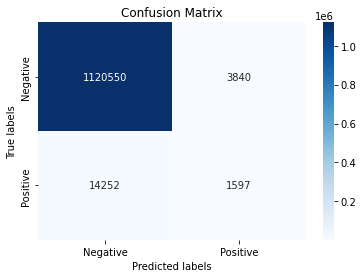


Train Classification Report and Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00   4497509
         1.0       0.70      0.51      0.59     63402

    accuracy                           0.99   4560911
   macro avg       0.85      0.75      0.79   4560911
weighted avg       0.99      0.99      0.99   4560911



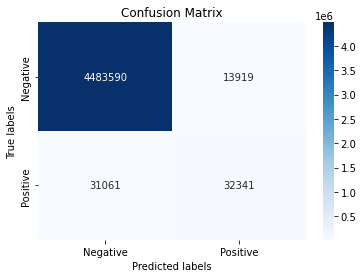

In [49]:
#Consolidated result from all cluster models

print("CV data - F1 score of RF model", round(f1_score(y_true_cv_all, y_pred_cv_all,average='macro'),2))
print("Train data - F1 score of RF model", round(f1_score(y_true_train_all, y_pred_train_all,average='macro'),2))

print(metrics.classification_report(y_true_cv_all, y_pred_cv_all))
print("CV Classification Report and Confusion Matrix")
print(metrics.classification_report(y_true_cv_all, y_pred_cv_all))
#print(metrics.confusion_matrix(y_true_all, y_pred_all))
plot_confusion_matrix(metrics.confusion_matrix(y_true_cv_all, y_pred_cv_all))

print("\nTrain Classification Report and Confusion Matrix")
print(metrics.classification_report(y_true_train_all, y_pred_train_all))
#print(metrics.confusion_matrix(y_true_all, y_pred_all))
plot_confusion_matrix(metrics.confusion_matrix(y_true_train_all, y_pred_train_all))

 Identify restaurants with most customers (most popular) in largely populated clusters of Solution#2 and recommend them as a generic solution to the 250 customers without any information.

- Identify the largely populated clusters 
- Shortlist the restaurants with large number of customers (having large number of positive class)